<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to demonstrate a format for defining (hierarchical) directed graphs and to use this for visualisation and pytorch module creation.

### Setup

In [0]:
!nvidia-smi

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastcore.git
!python -m pip install git+https://github.com/fastai/fastai2
!python -m pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
RANGER = 'https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py'

!wget $RANGER -O ranger.py
!wget $UTILS -O utils.py

### Graphs

In [0]:
from utils import *

Let's define a compact way of representing directed graphs (suitable for describing neural networks) as python dictionaries. Each node has a *name* which should be a string, a *value* which can be anything and an (ordered) list of *inputs* representing incoming edges from other nodes. Inputs are ordered as they typically represent function args. We can alternatively provide a dict of *inputs* to represent named args. Here is our graph format:


```
Graph := {name: (value, [input])}
```

or

```
Graph := {name: (value, {input_name: input}}
```

Here is an example of such a Graph using both kinds of inputs:


In [0]:
#define some node values - just strings for now, 
#we'll use more interesting values later
A, B, C, D = 'Aa', 'Bb', 'Cc', 'Dd'

graph = {
    'a': (A, []),
    'b': (B, ['a']),
    'c': (C, {'x': 'a', 'y': 'c'}),
    'd': (D, ['b'])
}

It will be useful to be able to display Graphs. Here is a function that does that:

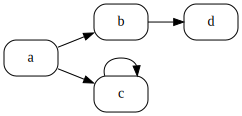

In [4]:
draw = lambda graph, max_depth=0: DotGraph({name: ({'tooltip': str(value)}, inputs) for name, (value, inputs) in graph.items()})
draw(graph)

The ```draw``` function above is just a thin wrapper around ```DotGraph``` which 
expects a standard Graph as input - with the constraint that *values* are dicts with fields that Graphviz understands (e.g. 'tooltip'.) If you hover over a node, you should see the *value* displayed as a tooltip. 

**Colors**

Let's make things a bit more interesting by adding some color based on a property of the nodes - in this case the value:

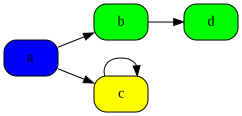

In [5]:
colors = {A: 'blue', B: 'green', C: 'yellow', D: 'green'}
draw = lambda graph, max_depth=0: DotGraph({name: ({'tooltip': str(value), 'fillcolor': colors[str(value)]}, inputs) for name, (value, inputs) in graph.items()})
draw(graph)

Choosing colors by hand is not the best use of our time so here's a helper to do it for us. ColorMap() is just a dictionary which populates itself with colors from a chosen palette when we ask for a missing key. Asking for the same key twice returns the same color which can be useful for coloring nodes consistently by some property (e.g. type.)

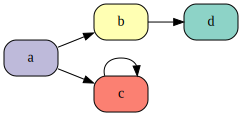

In [6]:
colors = ColorMap()
draw(graph)

We can inspect a ColorMap like this:

In [7]:
print(colors)

{'Aa': '#bebada', 'Bb': '#ffffb3', 'Cc': '#fb8072', 'Dd': '#8dd3c7'}


or like this:

In [8]:
colors

{'Aa': '#bebada', 'Bb': '#ffffb3', 'Cc': '#fb8072', 'Dd': '#8dd3c7'}

**Positional inputs**

Since python dicts are ordered (by insertion order) we can add an option to refer to nodes by position instead of name. It's convenient to use *relative* position so that -1 refers to the previous node. This is very useful for building pipelines where we don't necessarily know the name of the preceeding node, nor our absolute position in the graph.

To use this feature we just replace calls to ```graph.items()``` with ```iter_nodes(graph)``` which resolves positional node references. Here is a new ```draw``` function using ```iter_nodes```:

In [0]:
draw = lambda graph, max_depth=0: DotGraph({name: ({'tooltip': str(value), 'fillcolor': colors[str(value)]}, inputs) for name, (value, inputs) in iter_nodes(graph)})

And here is a graph with a mixture of named and (relative) positional inputs:

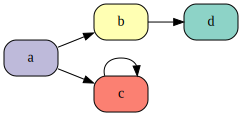

In [10]:
graph2 = {
    'a': (A, []),
    'b': (B, [-1]),
    'c': (C, ['a', 0]),
    'd': (D, [-2])
}
draw(graph2)

A common situation (in graphs which are mostly pipelines) is for a node to take the preceeding node as the only input. ```iter_nodes``` takes care of providing this default if we don't specify inputs to a node. Note that this is different from providing an *empty* list/dict as inputs, which means that a node has no inputs. Here is an example:

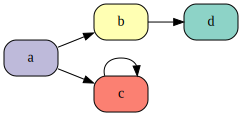

In [11]:
graph2 = {
    'a': (A, []),
    'b': B,
    'd': D,
    'c': (C, ['a', 0]),
}
draw(graph2)

We are free to refer to nodes which don't exist in the graph as inputs. These represent external nodes and don't have a value (so no 'tooltip' or 'fillcolor' in the diagram below.)

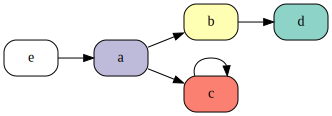

In [12]:
graph3 = {
    'a': (A, ['e']),
    'b': (B, [-1]),
    'c': (C, ['a', 0]),
    'd': (D, [-2])
}
draw(graph3)

**Nested graphs**

Sometimes we want to display a graph with nested structure. We can do this by adding path separators '/' in node names:

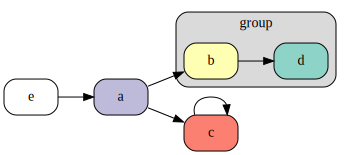

In [13]:
graph4 = {
    'a': (A, ['e']),
    'group/b': (B, ['a']),
    'c': (C, ['a', 'c']),
    'group/d': (D, ['group/b'])
}

draw(graph4)

We can have multiple levels of nesting and we can mix-and-match with relative positional inputs:

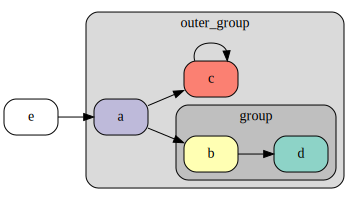

In [14]:
graph5 = {
    'outer_group/a': (A, ['e']),
    'outer_group/group/b': B,
    'outer_group/c': (C, [-2, 'outer_group/c']),
    'outer_group/group/d': (D, ['outer_group/group/b'])
}
draw(graph5)

It's annoying to have to add path prefixes to every node name and input. We want to be able to write this as a hierarchical graph, some of whose node *values* are themselves *graphs*. Let's express the graph above in hierarchical form. First we define a graph for the nodes in 'group':

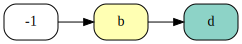

In [15]:
group = {'b': B, 'd': D}
draw(group)

Note that if we don't like the default name -1 for the (external) input to node 'b' we can always name it instead:

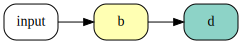

In [16]:
draw({'b': (B, ['input']), 'd': D})

Next we define a graph representing the 'outer_group' in which the 'group' graph that we just defined appears as the value of a node - its input being node 'a'. You can inspect the value of node 'group' using its tooltip.

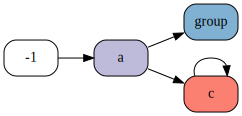

In [17]:
outer_group = {'a': A, 'group': (group, ['a']), 'c': (C, ['a', 'c'])}
draw(outer_group)

As usual we could have left the input to the 'group' node empty and it would default to the previous node which is 'a' anyway. Finally let's define the full graph which has a single node 'outer_group' and a single input 'e':

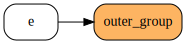

In [18]:
graph6 = {'outer_group': (outer_group, ['e'])}
draw(graph6)

We can display the full nested structure by 'exploding' the hierarchical graph into a flat graph with path separated names:

In [19]:
explode(graph6)

{'outer_group/a': ('Aa', ['e']),
 'outer_group/c': ('Cc', ['outer_group/a', 'outer_group/c']),
 'outer_group/group/b': ('Bb', ['outer_group/a']),
 'outer_group/group/d': ('Dd', ['outer_group/group/b'])}

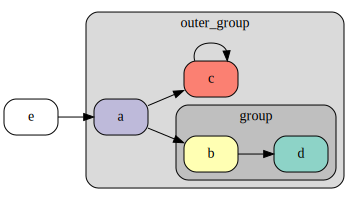

In [20]:
draw(explode(graph6))

We can also display intermediate levels of hierarchy by specifiying a max_levels (to expand) argument:

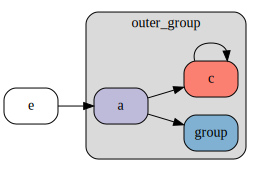

In [21]:
draw(explode(graph6, max_levels=1))

Here's a test that exploding in two stages is the same as doing it all at once:

In [0]:
#test
assert explode(explode(graph6, 1), 1) == explode(graph6)

Here's a more complicated graph with repeated groups and name clashes:

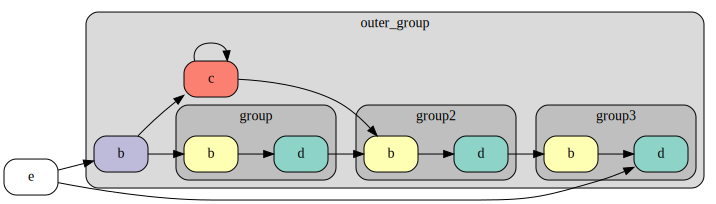

In [23]:
graph7 = {
    'outer_group': ({
        'b': A,  
        'group':  {'b': B, 'd': D},
        'group2': ({'b': (B, ['in1', 'in2']), 'd': D}, [-1, 'c']),
        'group3':  {'b': B, 'd': (D, [-1, 'e'])},
        'c': (C, ['b', 0]),
    }, ['e'])}

draw(explode(graph7))

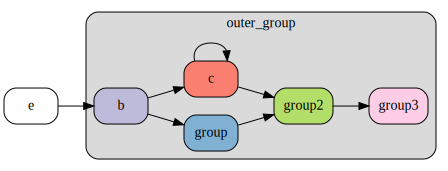

In [24]:
draw(explode(graph7, 1))

Note that the input from 'e' to 'group3/d' is passed directly inside the definition of the 'group3' node and is not visible to the hierarchical structure which is why the edge (correctly) does not appear in the partially exploded graph. Generally this is bad practice: one wants the hierarchy to reflect the full structure and to avoid hard-coding external dependencies inside components. The information is still there though and a second call to explode correctly restores the missing edge: 

In [0]:
#test
assert explode(explode(graph7, 1), 1) == explode(graph7)

### Pytorch

Let's use the Graph datastructure that we've developed to define some pytorch models. The Network class is a pytorch module defined by a graph in a similar spirit to nn.Sequential (but much better!)

In [0]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import fastai, fastai.vision
import fastai2, fastai2.callback.all
import ranger

class Mul(nn.Module):
    def forward(self, x, y): return x * y

class Add(nn.Module):
    def forward(self, x, y): return x + y

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, *args, zero=False, **kwargs):
        super().__init__(*args, **kwargs)
        if self.affine:
            self.weight.data.fill_(0. if zero else 1.)

class Network(nn.Module):
    def __init__(self, graph, cache_activations=False):
        super().__init__()
        self.cache_activations = cache_activations
        self.graph = bind({k: (Network(v) if isinstance(v, dict) else v,i) for (k, (v,i)) in pipeline(graph) if v is not None}, {-1: 'input'})
        for path, (val, _) in iter_nodes(self.graph): 
            setattr(self, path.replace('/', '_'), val)
    
    def forward(self, *args):
        outputs = dict(zip(external_inputs(self.graph), args))
        for k, (node, inputs) in iter_nodes(self.graph):
            if k not in outputs: 
                outputs[k] = node(*[outputs[x] for x in inputs])
        if self.cache_activations: self.cache = outputs
        return outputs[k]

    def explode(self, max_levels=-1):
        return Network(explode(self.graph, max_levels))

colors = ColorMap()
def draw(network, **kwargs):
    graph = network.graph if isinstance(network, Network) else network
    return DotGraph({p: ({'fillcolor': colors[type(v).__name__], 'tooltip': str(v)}, inputs) for p, (v, inputs) in iter_nodes(graph)}, **kwargs)

### Layers

In [28]:
class ConvLayer(Network):
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, groups=1, bias=None, norm=BatchNorm, act_cls=MishJit, conv=nn.Conv2d):
        super().__init__({
        'conv': nn.Conv2d(ni, nf, ks, stride=stride, padding=((ks-1)//2 if padding is None else padding), groups=groups, bias=bias),
        'norm': norm(nf) if callable(norm) else norm, 
        'act': act_cls()
    })

draw(ConvLayer(32,64), size=3)

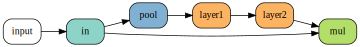

In [29]:
class SEModule(Network):
    def __init__(self, ch, reduction):
        super().__init__({
        'in': nn.Identity(),
        'pool': nn.AdaptiveAvgPool2d(1),
        'layer1': ConvLayer(ch, ch//reduction, ks=1, norm=None, bias=True, act_cls=nn.ReLU),
        'layer2': ConvLayer(ch//reduction, ch, ks=1, norm=None, bias=True, act_cls=nn.Sigmoid),
        'mul': (Mul(), [-1, 'in']),
    })

mod = SEModule(64, 16)
draw(mod, size=5)

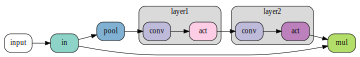

In [30]:
draw(mod.explode(), size=5)

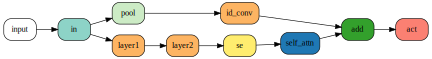

In [31]:
#res_block with expansion=1
class ResBlockA(Network):
    def __init__(self, ni, nf, stride=1, groups=1, groups2=1, sa=False, reduction=None, nh=None, norm=BatchNorm, act_cls=MishJit):
        if nh is None: nh = nf
        super().__init__({
            'in': nn.Identity(),
            'pool': (None if stride==1 else nn.AvgPool2d(2, ceil_mode=True)),
            'id_conv': (nn.Identity() if ni==nf else ConvLayer(ni, nf, ks=1, act_cls=nn.Identity)),
            'layer1': (ConvLayer(ni, nh, 3, stride=stride, groups=groups, norm=norm, act_cls=act_cls), ['in']),
            'layer2': ConvLayer(nh, nf, 3, groups=groups2, norm=partial(norm, zero=True), act_cls=nn.Identity),
            'se': (SEModule(nf, reduction=reduction) if reduction else None),
            'self_attn': (fastai2.layers.SimpleSelfAttention(nf, ks=1, sym=0) if sa else None),
            'add': (Add(), [-1, 'id_conv']),
            'act': act_cls()
        })

mod = ResBlockA(32, 64, stride=2, reduction=16, sa=True)
draw(mod, size=6)

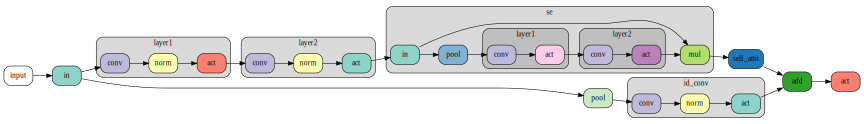

In [32]:
draw(mod.explode(), size=12)

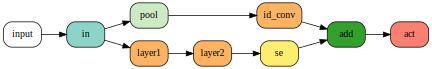

In [33]:
def separable_block(ni, nf, reduction=16, stride=1, **kwargs):
    return ResBlockA(ni,  nf, stride=stride, reduction=reduction, nh=nf*2, groups=ni, **kwargs)

draw(separable_block(32, 64, stride=2), size=6)

In [0]:
def xresnet_stem(sizes, act_cls):
    return dict({f'layer{i+1}': ConvLayer(sizes[i], sizes[i+1],  stride=2 if i==0 else 1, act_cls=act_cls) for i in range(len(sizes)-1)},
                pool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def xresnet_block_spec(layers,  sizes):
    return [[{'ni': sizes[i],   'nf': sizes[i+1], 'stride': 1 if i==0 else 2}] + 
            [{'ni': sizes[i+1], 'nf': sizes[i+1], 'stride': 1}] * (l-1) 
            for i,l in enumerate(layers)]

def make_blocks(block, spec):
    return {f'stage{i}': {f'block{j}': block(**kw) for j,kw in enumerate(stage,1)} for i,stage in enumerate(spec,1)}

def xresnet_head(n_features, c_out, p):
    return {
        'pool': nn.AdaptiveAvgPool2d(1), 
        'flatten': fastai2.layers.Flatten(),
        'dropout': (None if p is None else nn.Dropout(p)),
        'classifier': nn.Linear(n_features, c_out)
    }

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: 
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): 
        nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
    return m

class XResNet(Network):
    def __init__(self, block, layers, c_in, c_out, sa=False, p=None, act_cls=MishJit, stem_sizes=None, layer_sizes=None, stem_func=xresnet_stem):
        if not stem_sizes: 
            stem_sizes = [16,32,64] if c_in < 3 else [32,64,64]
        if not layer_sizes:
            layer_sizes = [64,128,256,512] + [256]*(len(layers)-4)
        block_spec = xresnet_block_spec(layers, [stem_sizes[-1]] + layer_sizes)
        if sa: block_spec[-4][-1]['sa'] = True
        super().__init__(union(
            {'stem': stem_func([c_in] + stem_sizes, act_cls)}, 
            make_blocks(partial(block, act_cls=act_cls), block_spec),
            xresnet_head(layer_sizes[-1], c_out, p)
        ))
        init_cnn(self)

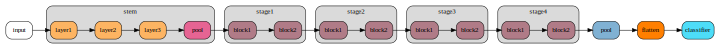

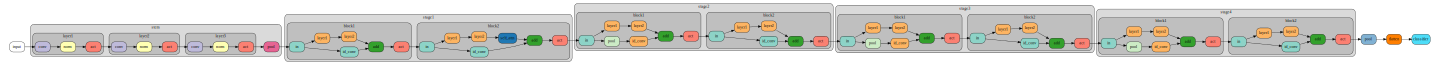

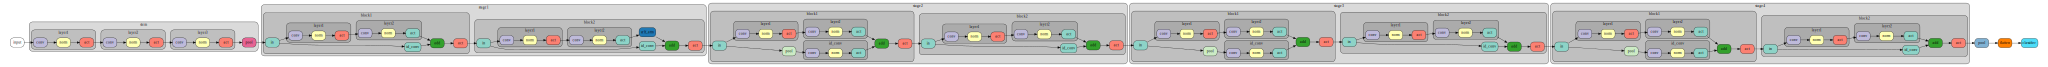

In [35]:
model = XResNet(ResBlockA, [2,2,2,2], c_in=3, c_out=10, sa=True)
display(draw(model, size=6))
display(draw(model.explode(1), size=10))
display(draw(model.explode(2), size=20))
display(draw(model.explode(), size=40))

In [0]:
#test that the exploded network computes the same things as the unexploded version
m = model.cuda()
inputs = torch.randn(64,3,128,128).cuda()
assert torch.sum(torch.abs(m(inputs) - m.explode()(inputs))).item() == 0.0

### Training

In [0]:
data_dir = fastai.datasets.untar_data(fastai.datasets.URLs.IMAGENETTE_160)
device = torch.device(torch.cuda.current_device())

torch.backends.cudnn.benchmark = True

In [0]:
size = 128
bs = 64
random_aspect_ratio = (3/4, 4/3)
random_area = (0.35, 1.)
val_xtra_size = 32

to = lambda dtype: (lambda b: (b[0].to(dtype), b[1]))

train_dl = lambda folder, bs, dtype=torch.float16: (
        Map(to(dtype), DALIDataLoader(imagenet_train_graph(folder, size, random_aspect_ratio, random_area), bs, drop_last=True, device=device)))
valid_dl = lambda folder, bs, dtype=torch.float16: Chain(
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size), bs, drop_last=False, device=device)),
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size, mirror=1), bs, drop_last=False, device=device)),
    )

data = lambda data_dir=data_dir, bs=bs, dtype=torch.float16: fastai2.basics.DataBunch(train_dl(data_dir/'train', bs, dtype), valid_dl(data_dir/'val', bs, dtype))

In [0]:
def smoothed_acc(logits, targets, beta=3.): #replace argmax with soft(arg)max
    return torch.mean(nn.functional.softmax(logits*beta, dim=-1)[torch.arange(0, targets.size(0), device=device), targets])

RangerWrapper = lambda *args, **kwargs: fastai2.basics.OptimWrapper(ranger.Ranger(*args, **kwargs))

def add_opt(learn):
    skip_wd = split_params((lambda mod, name: isinstance(mod, nn.BatchNorm2d) or name=='bias'), learn.model)
    learn.opt = learn.opt_func([{'params': skip_wd[False]}, {'params': skip_wd[True]}], lr=0.1)
    return learn

learner_v2 = lambda data, model: add_opt(
    fastai2.basics.Learner(
        data, model, lr=0.0,
        opt_func=partial(RangerWrapper, betas=(0.95, 0.99), eps=1e-6),
        metrics=[fastai2.metrics.accuracy, smoothed_acc],
        loss_func=fastai2.basics.LabelSmoothingCrossEntropy())
    )

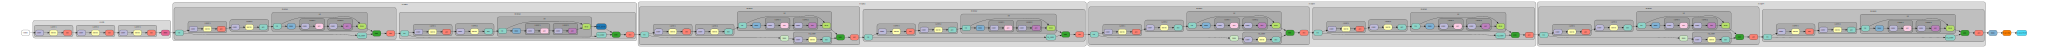

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.375807,1.346774,0.670000,0.636506,00:17
1,1.120002,0.972087,0.824000,0.804064,00:15
2,1.006834,1.060193,0.773000,0.757944,00:16
3,0.936122,0.825176,0.893000,0.876253,00:16
4,0.821548,0.783778,0.895000,0.888897,00:16


In [40]:
learn = learner_v2(data(dtype=torch.float), XResNet(separable_block, [2,2,2,2], c_in=3, c_out=10, sa=True))
display(draw(learn.model.explode(), size=40))
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)